In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("/content/ecommerce_customer_behavior_dataset_v2.csv")
df.head()

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_000001-1,CUST_00001,2023-05-29,40,Male,Ankara,Books,29.18,1,0.00,29.18,Digital Wallet,Mobile,14,9,True,13,4
1,ORD_000001-2,CUST_00001,2023-10-12,40,Male,Ankara,Home & Garden,644.40,1,138.05,506.35,Credit Card,Desktop,14,8,True,6,2
2,ORD_000001-3,CUST_00001,2023-12-05,40,Male,Ankara,Sports,332.82,5,0.00,1664.10,Credit Card,Mobile,15,10,True,9,4
3,ORD_000002-1,CUST_00002,2023-05-11,33,Male,Istanbul,Food,69.30,5,71.05,275.45,Digital Wallet,Desktop,16,13,True,4,4
4,ORD_000002-2,CUST_00002,2023-06-16,33,Male,Istanbul,Beauty,178.15,3,0.00,534.45,Credit Card,Mobile,14,7,True,6,4


In [3]:
df.shape

(17049, 18)

STEP 1 — Load Cleaned Data into SQL

 loading the cleaned dataset into a SQL database to perform analytical queries

In [4]:
import sqlite3


# Create SQLite database
conn = sqlite3.connect("ecommerce.db")

# Write dataframe to SQL table
df.to_sql("ecommerce_sales", conn, if_exists="replace", index=False)

print("Data loaded into SQL table: ecommerce_sales")


Data loaded into SQL table: ecommerce_sales


STEP 2 — First SQL Validation Query

 validating the dataset by checking row counts and unique identifiers.

In [5]:
query = """
SELECT
    COUNT(*) AS total_rows,
    COUNT(DISTINCT Order_ID) AS total_orders,
    COUNT(DISTINCT Customer_ID) AS total_customers
FROM ecommerce_sales;
"""

pd.read_sql(query, conn)


,total_rows,total_orders,total_customers
0,17049,17049,5000


 STEP 3 — CORE BUSINESS SQL QUERIES
 1. Total Revenue
 2. Monthly Revenue Trend
 3. Revenue by Product Category
 4. Revenue by City
 5. Returning vs New Customers

In [6]:
#Total revenue
query = """
SELECT
    SUM(Total_Amount) AS total_revenue
FROM ecommerce_sales;
"""
pd.read_sql(query, conn)

,total_revenue
0,21779052.59


In [7]:
# Monthly Revenue Trend
query="""SELECT
    strftime('%Y', Date) AS Year,
    strftime('%m', Date) AS Month,
    SUM(Total_Amount) AS monthly_revenue
FROM ecommerce_sales
GROUP BY Year, Month
ORDER BY Year, Month;
"""
pd.read_sql(query,conn)

,Year,Month,monthly_revenue
0,2023,01,1311603.21
1,2023,02,1409777.29
2,2023,03,1458005.58
3,2023,04,1499648.03
4,2023,05,1483511.61
5,2023,06,1380984.94
6,2023,07,1560046.14
7,2023,08,1510999.75
8,2023,09,1502164.37
9,2023,10,1536847.33


In [8]:
# Revenue by Product Category
query = """
SELECT
    Product_Category,
    SUM(Total_Amount) AS category_revenue
FROM ecommerce_sales
GROUP BY Product_Category
ORDER BY category_revenue DESC;
"""
pd.read_sql(query, conn)

,Product_Category,category_revenue
0,Electronics,10481897.65
1,Home & Garden,4023903.94
2,Sports,3205086.99
3,Fashion,1577035.70
4,Toys,1014237.53
5,Beauty,694437.02
6,Food,422054.65
7,Books,360399.11


In [9]:
# Revenue by City
query = """
SELECT
    City,
    SUM(Total_Amount) AS city_revenue
FROM ecommerce_sales
GROUP BY City
ORDER BY city_revenue DESC;
"""
pd.read_sql(query, conn)

,City,city_revenue
0,Istanbul,5646595.78
1,Ankara,3052443.10
2,Izmir,2651743.92
3,Bursa,2317028.10
4,Antalya,1661594.15
5,Gaziantep,1573422.25
6,Adana,1512320.19
7,Konya,1363152.80
8,Kayseri,1091658.53
9,Eskisehir,909093.77


In [10]:
# Returning vs New Customers
query = """
SELECT
    Is_Returning_Customer,
    SUM(Total_Amount) AS revenue
FROM ecommerce_sales
GROUP BY Is_Returning_Customer;
"""
pd.read_sql(query, conn)

,Is_Returning_Customer,revenue
0,0,2588332.13
1,1,19190720.46


RFM CUSTOMER SEGMENTATION

In [12]:

from datetime import timedelta

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Reference date = last date in dataset + 1 day
reference_date = df["Date"].max() + timedelta(days=1)

rfm = (
    df.groupby("Customer_ID")
    .agg({
        "Date": lambda x: (reference_date - x.max()).days,  # Recency
        "Order_ID": "nunique",                               # Frequency
        "Total_Amount": "sum"                                # Monetary
    })
    .reset_index()
)

rfm.columns = ["Customer_ID", "Recency", "Frequency", "Monetary"]
rfm.head()


,Customer_ID,Recency,Frequency,Monetary
0,CUST_00001,112,3,2199.63
1,CUST_00002,284,2,809.90
2,CUST_00003,83,2,3030.81
3,CUST_00004,42,1,383.22
4,CUST_00005,279,3,2422.73


Score Customers

In [13]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()


,Customer_ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,CUST_00001,112,3,2199.63,2,2,2,222
1,CUST_00002,284,2,809.90,1,1,1,111
2,CUST_00003,83,2,3030.81,3,1,3,313
3,CUST_00004,42,1,383.22,3,1,1,311
4,CUST_00005,279,3,2422.73,1,2,2,122


here we are Creating Business-Friendly Segments

In [14]:
def segment_customer(row):
    if row["R_Score"] == 4 and row["F_Score"] >= 3:
        return "Champions"
    elif row["F_Score"] >= 3:
        return "Loyal Customers"
    elif row["R_Score"] >= 3:
        return "Potential Loyalists"
    else:
        return "At Risk"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)
rfm["Segment"].value_counts()


,count
Segment,
At Risk,1982
Potential Loyalists,1173
Loyal Customers,1096
Champions,749


Discount Rate

In [15]:
df["Gross_Amount"] = df["Unit_Price"] * df["Quantity"]
df["Discount_Rate"] = df["Discount_Amount"] / df["Gross_Amount"]
df["Discount_Rate"] = df["Discount_Rate"].fillna(0)


Discount Buckets

In [16]:
df["Discount_Bucket"] = pd.cut(
    df["Discount_Rate"],
    bins=[-0.01, 0, 0.10, 0.25, 1.0],
    labels=["No Discount", "Low (0-10%)", "Medium (10-25%)", "High (25%+)"]
)


Analyzing Revenue by Discount Level

In [17]:
discount_analysis = (
    df.groupby("Discount_Bucket")
    .agg(
        Orders=("Order_ID", "count"),
        Avg_Order_Value=("Total_Amount", "mean"),
        Total_Revenue=("Total_Amount", "sum")
    )
    .reset_index()
)

discount_analysis


/tmp/ipython-input-230661024.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Discount_Bucket")


,Discount_Bucket,Orders,Avg_Order_Value,Total_Revenue
0,No Discount,10572,1338.279490,14148290.77
1,Low (0-10%),1910,1263.088932,2412499.86
2,Medium (10-25%),4567,1142.601699,5218261.96
3,High (25%+),0,NaN,0.00


Delivery Time Buckets

In [18]:
df["Delivery_Bucket"] = pd.cut(
    df["Delivery_Time_Days"],
    bins=[0, 3, 7, 14, 30],
    labels=["Fast (1-3)", "Normal (4-7)", "Slow (8-14)", "Very Slow (15+)"]
)


Analyzing Ratings by Delivery Speed

In [19]:
delivery_rating = (
    df.groupby("Delivery_Bucket")
    .agg(
        Avg_Rating=("Customer_Rating", "mean"),
        Orders=("Order_ID", "count")
    )
    .reset_index()
)

delivery_rating


/tmp/ipython-input-3196690215.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Delivery_Bucket")


,Delivery_Bucket,Avg_Rating,Orders
0,Fast (1-3),3.908463,3332
1,Normal (4-7),3.904878,8221
2,Slow (8-14),3.887871,5021
3,Very Slow (15+),3.863158,475


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")  # nice default look


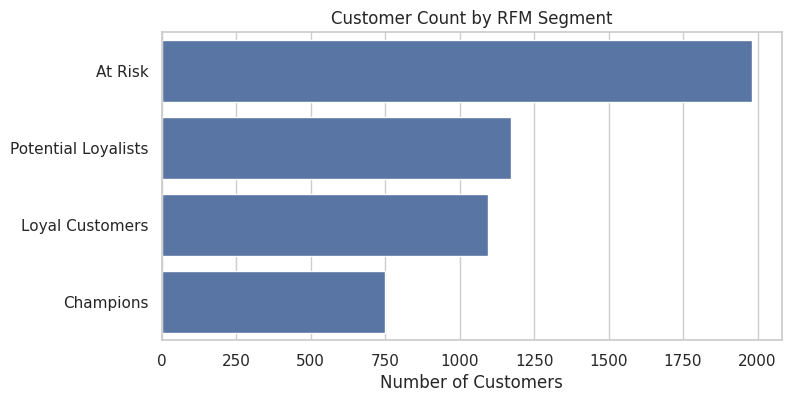

In [21]:
segment_counts = rfm["Segment"].value_counts().reset_index()
segment_counts.columns = ["Segment", "Customers"]

plt.figure(figsize=(8,4))
sns.barplot(data=segment_counts, x="Customers", y="Segment")
plt.title("Customer Count by RFM Segment")
plt.xlabel("Number of Customers")
plt.ylabel("")
plt.show()


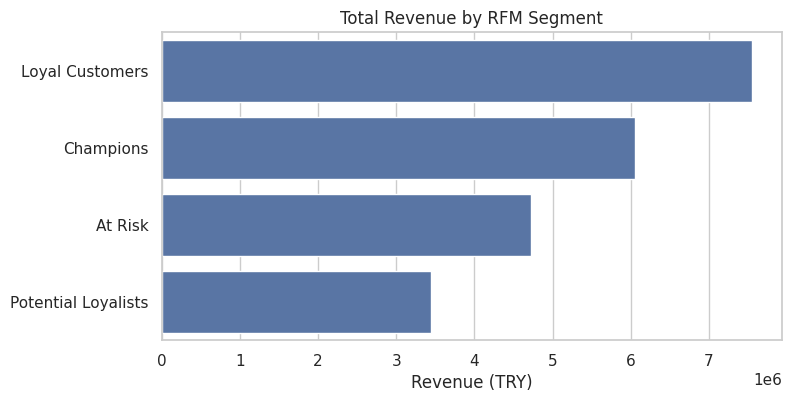

In [22]:
segment_revenue = (
    df.merge(rfm[["Customer_ID", "Segment"]], on="Customer_ID", how="left")
      .groupby("Segment")["Total_Amount"].sum()
      .sort_values(ascending=False)
      .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(data=segment_revenue, x="Total_Amount", y="Segment")
plt.title("Total Revenue by RFM Segment")
plt.xlabel("Revenue (TRY)")
plt.ylabel("")
plt.show()


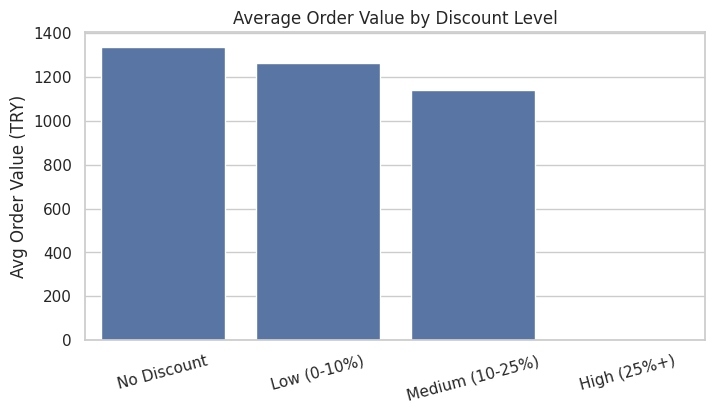

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(data=discount_analysis, x="Discount_Bucket", y="Avg_Order_Value")
plt.title("Average Order Value by Discount Level")
plt.xlabel("")
plt.ylabel("Avg Order Value (TRY)")
plt.xticks(rotation=15)
plt.show()


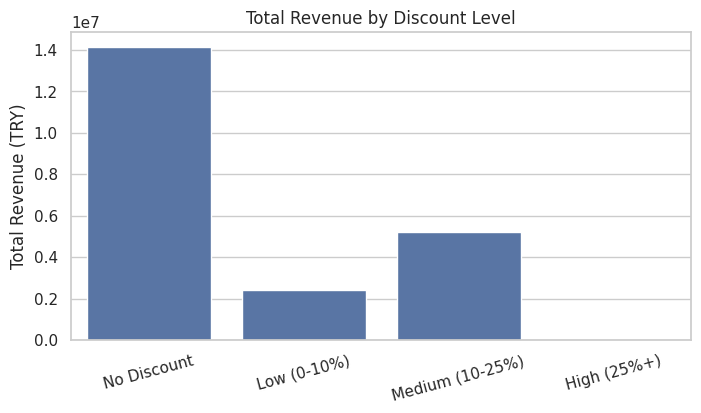

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(data=discount_analysis, x="Discount_Bucket", y="Total_Revenue")
plt.title("Total Revenue by Discount Level")
plt.xlabel("")
plt.ylabel("Total Revenue (TRY)")
plt.xticks(rotation=15)
plt.show()


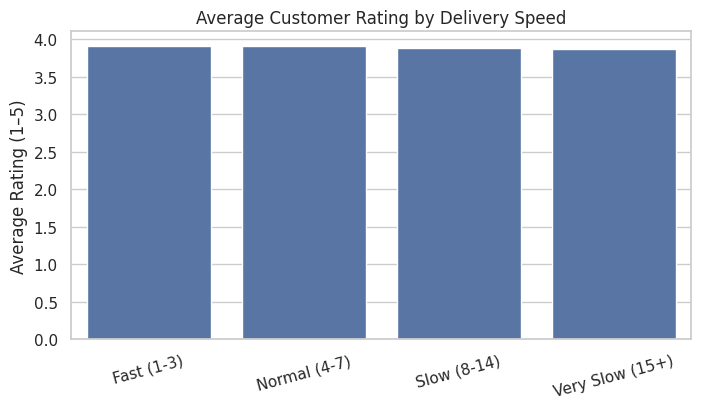

In [25]:
plt.figure(figsize=(8,4))
sns.barplot(data=delivery_rating, x="Delivery_Bucket", y="Avg_Rating")
plt.title("Average Customer Rating by Delivery Speed")
plt.xlabel("")
plt.ylabel("Average Rating (1–5)")
plt.xticks(rotation=15)
plt.show()


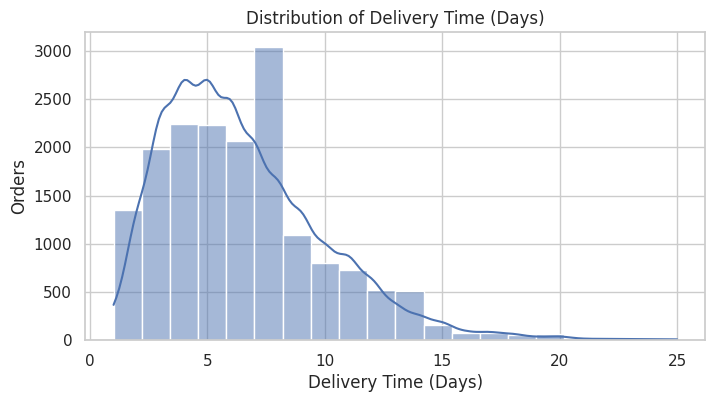

In [26]:
plt.figure(figsize=(8,4))
sns.histplot(df["Delivery_Time_Days"], bins=20, kde=True)
plt.title("Distribution of Delivery Time (Days)")
plt.xlabel("Delivery Time (Days)")
plt.ylabel("Orders")
plt.show()


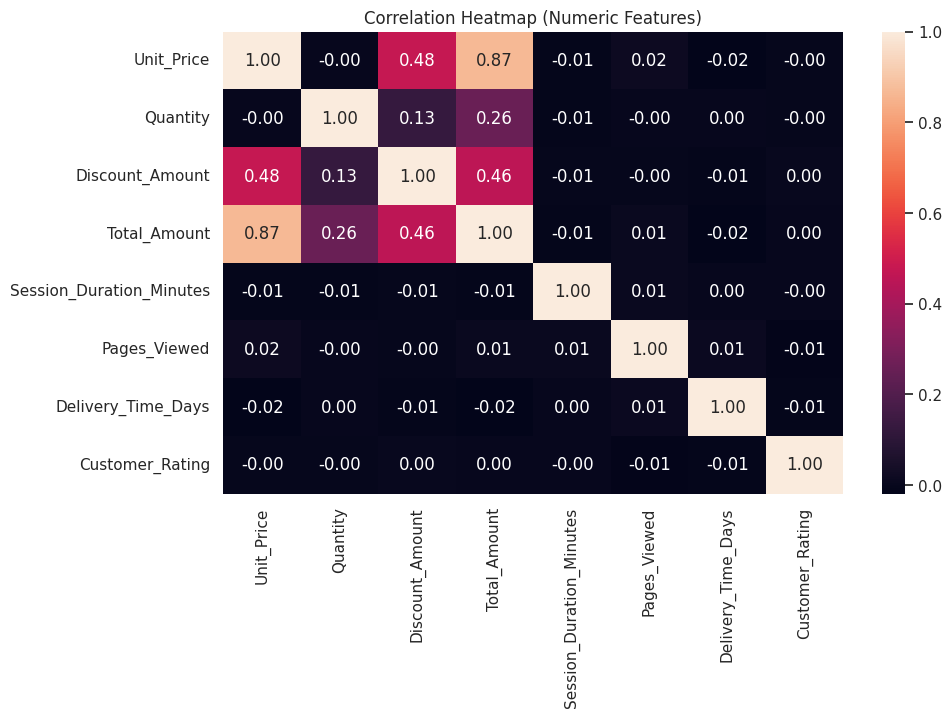

In [31]:
num_cols = [
    "Unit_Price", "Quantity", "Discount_Amount", "Total_Amount",
    "Session_Duration_Minutes", "Pages_Viewed",
    "Delivery_Time_Days", "Customer_Rating"
]

corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()
